In [5]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
from helper import Helper

class Calibrator:
    def __init__(self, x_corners, y_corners):        

        self.nx = x_corners
        self.ny = y_corners        
        
        #Has to be computed in compute_img_pts()
        self.objpoints = []
        self.imgpoints = []        
        
        #Calibration params. should be computed in calibrate_camera()
        self.calib_params = {}
    def compute_img_pts(self, calib_images_path, show_corners=True):
        
        objp = np.zeros((self.ny * self.nx, 3), np.float32)
        objp[:,:2] = np.mgrid[0:self.nx, 0:self.ny].T.reshape(-1, 2)
            
        # Make a list of calibration images
        images = glob.glob(calib_images_path)

        # Step through the list and search for chessboard corners
        for idx, fname in enumerate(images):
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (self.nx, self.ny), None)

            
            # If found, add object points, image points
            if ret == True:
                self.objpoints.append(objp)
                self.imgpoints.append(corners)

                # Draw and display the corners
                cv2.drawChessboardCorners(img, (self.nx, self.ny), corners, ret)        
                
                if show_corners:
                    plt.imshow(img)
                    plt.show()
        
        print ('corners found. please check self.imgpoints')
    
    def calibrate_camera(self, image_path):
        if len(self.imgpoints) == 0 or len(self.objpoints) == 0:
            raise Exception("calibration unsuccessful. Have you executed compute_img_pts() ?")
        
        img = cv2.imread(image_path)
        img_size = (img.shape[1], img.shape[0])
        
        self.calib_params['ret'], \
        self.calib_params['mtx'], \
        self.calib_params['dist'], \
        self.calib_params['rvecs'], \
        self.calib_params['tvecs'] = cv2.calibrateCamera(self.objpoints, self.imgpoints, img_size, None, None)
        
        return self.calib_params
        
        
    def store_calib_coeffs(self, store_path):
        if len(self.calib_params) == 0:
            raise Exception('calib_params is empty. Have you run calibrate_camera ??')
            
        pickle.dump( self.calib_params, open( store_path, "wb" ) )
        print ('stored calib coeffs @ ' + store_path)
        
    
    def undistort_image(self, img):
        dst = cv2.undistort(img, self.calib_params['mtx'], self.calib_params['dist'], None, self.calib_params['mtx'])
        return dst


corners found. please check self.imgpoints
stored calib coeffs @ ../data/calib_coeffs.pickle


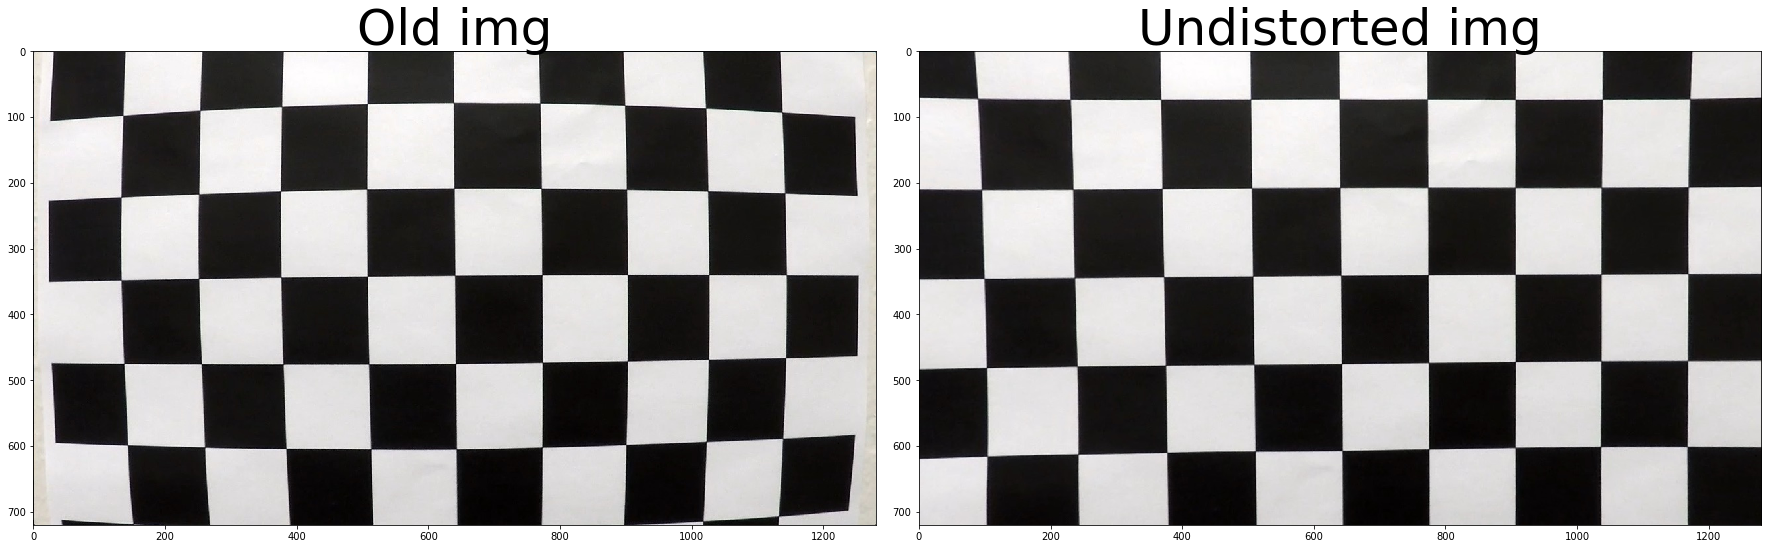

In [6]:
h = Helper()

cal = Calibrator(x_corners=9, y_corners=6)

calib_images_path = '../camera_cal/*.jpg'
cal.compute_img_pts(calib_images_path, False)

test_image_path = '../camera_cal/calibration1.jpg'
cal.calibrate_camera(test_image_path)

cal.store_calib_coeffs('../data/calib_coeffs.pickle')

img = h.load_image(test_image_path)
und_img = cal.undistort_image(img)
h.parallel_plots(img, 'Old img', und_img, 'Undistorted img')

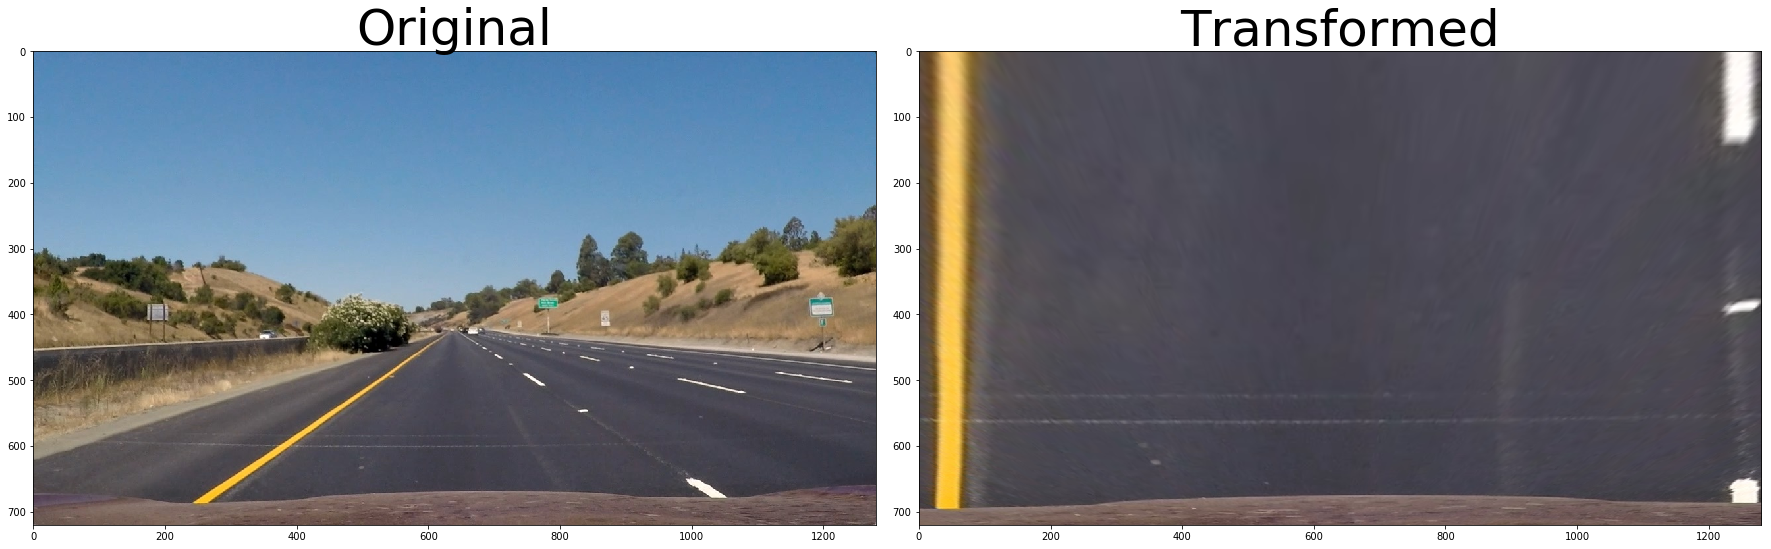

In [7]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
from helper import Helper


class Transformer:
    def __init__(self):
        pass
    
    def transform(self, img, corners, offset):

        x = img.shape[1]
        y = img.shape[0]
        
        src = np.float32(corners)

        img_size = (x, y)    

        dst = np.float32([(0 + offset, 0 + offset), \
                          (x - offset, 0 + offset), \
                          (x - offset, y - offset), \
                          (0 + offset, y - offset)])

        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        return warped, M

h = Helper()

img = h.load_image('../test_images/straight_lines1.jpg')  
t = Transformer()
corners = [(525, 499), (760, 499), (1026, 673), (270, 673)]
top_down, perspective_M = t.transform(img,corners , offset=40)
h.parallel_plots(img, 'Original', top_down, 'Transformed')


In [51]:
class Thresholder:
    def __init__(self):
        pass

    def absolute_threshold(self, img, orient='x', thresh_min=0, thresh_max=255, sobel_kernel=3):

            
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
        binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        # Return the result
        return binary_output
    
    def magnitude_threshold(self, img, sobel_kernel=3, mag_thresh=(0, 255)):
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

        # Return the binary image
        return binary_output
    
    def direction_threshold(self, img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
        # Apply the following steps to img
        # 1) Convert to grayscale
        # 2) Take the gradient in x and y separately
        # 3) Take the absolute value of the x and y gradients
        # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
        # 5) Create a binary mask where direction thresholds are met
        # 6) Return this mask as your binary_output image
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
        abs_sobelx  = np.sqrt(np.square(sobelx)) 
        abs_sobely  = np.sqrt(np.square(sobely))
        direction = np.arctan2(abs_sobely, abs_sobelx)
        sbinary = np.zeros_like(direction)
        sbinary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
        return sbinary

    def hls_threshold(self, img, thresh=(0, 255)):
        # 1) Convert to HLS color space
        # 2) Apply a threshold to the S channel
        # 3) Return a binary image of threshold result
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        S = hls[:,:,2]
        binary_output = np.zeros_like(S)
        binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
        
        return binary_output
    
    
    
    

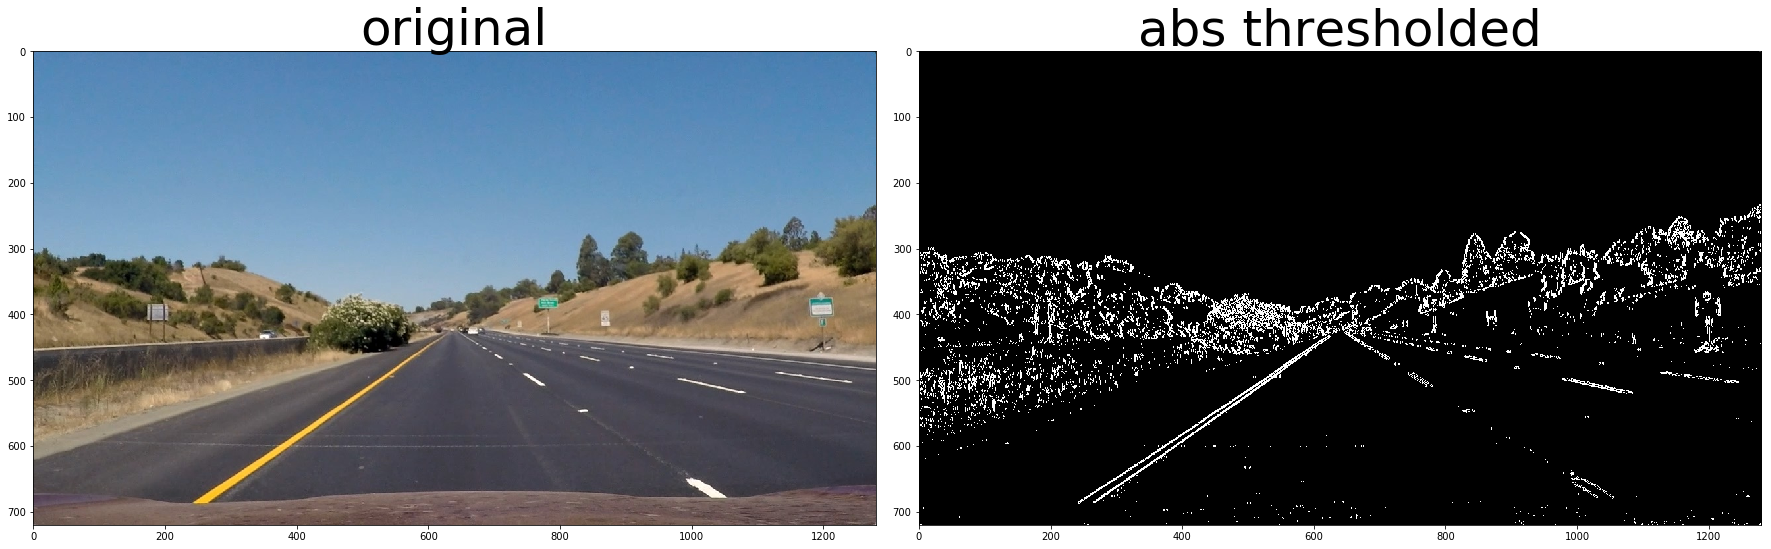

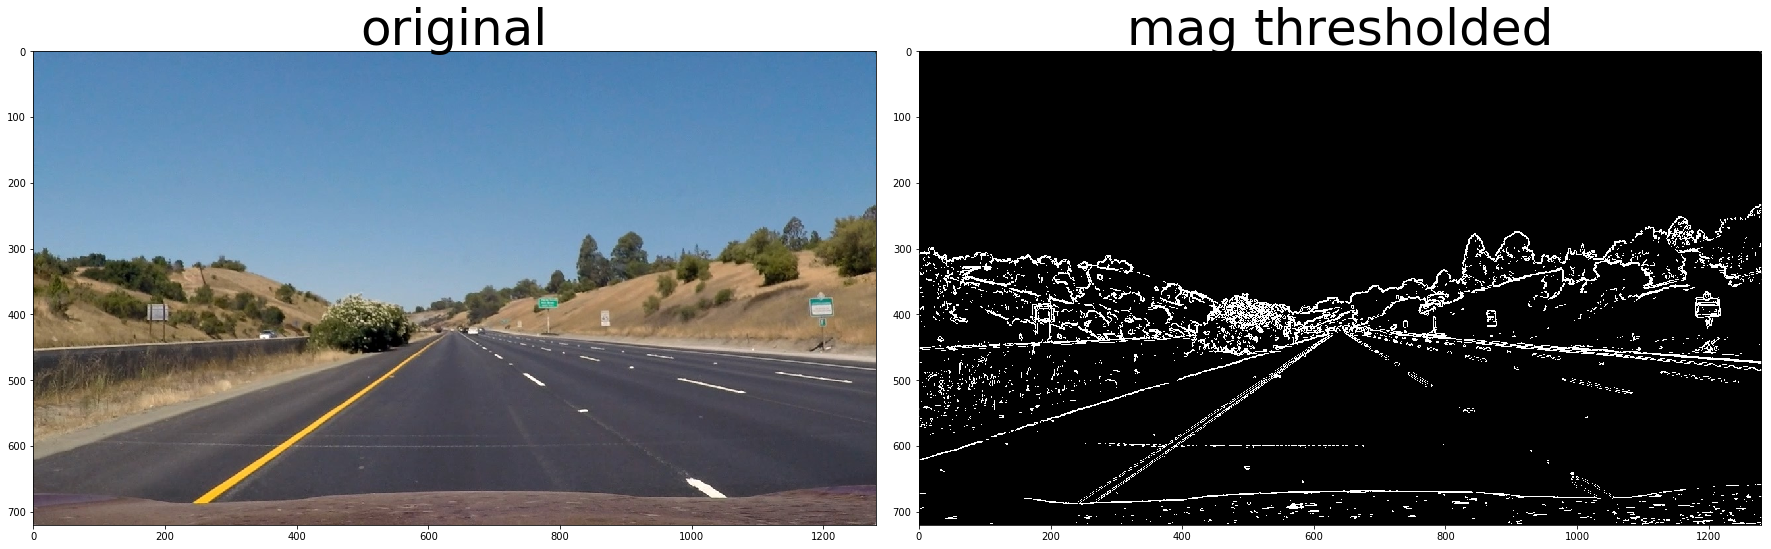

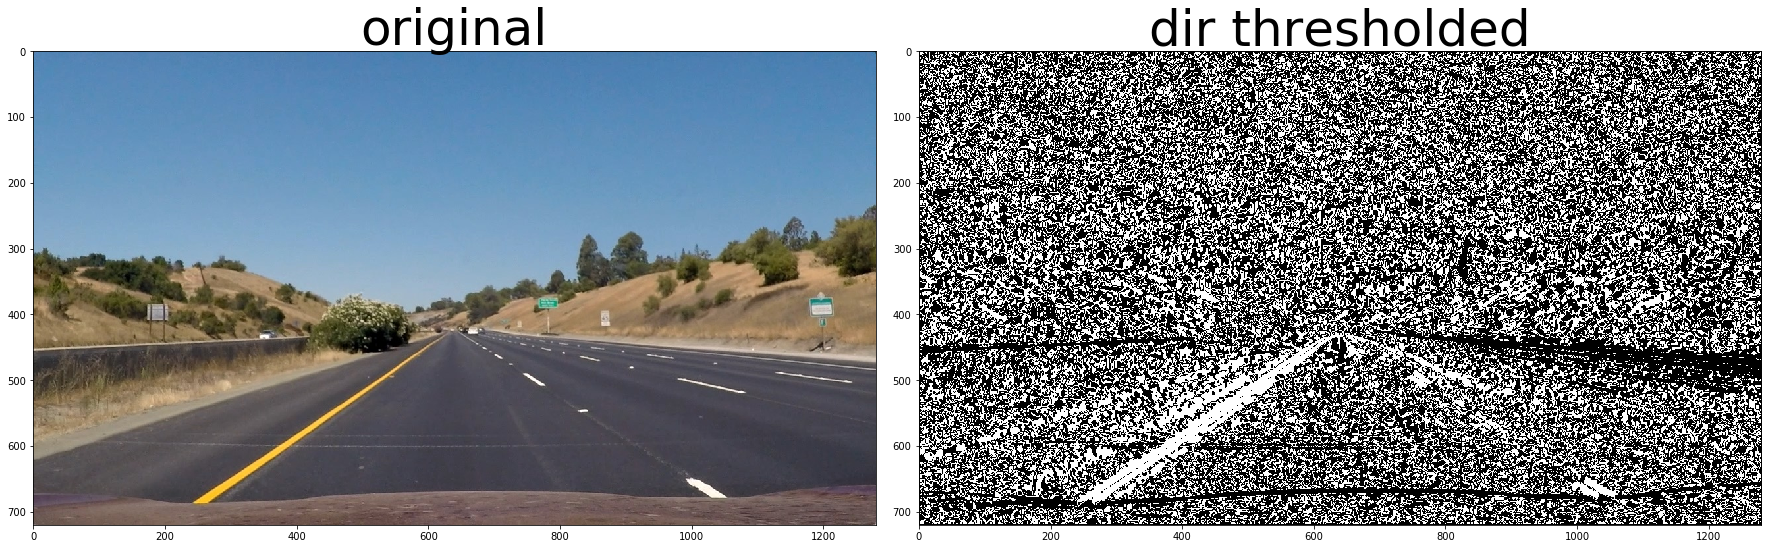

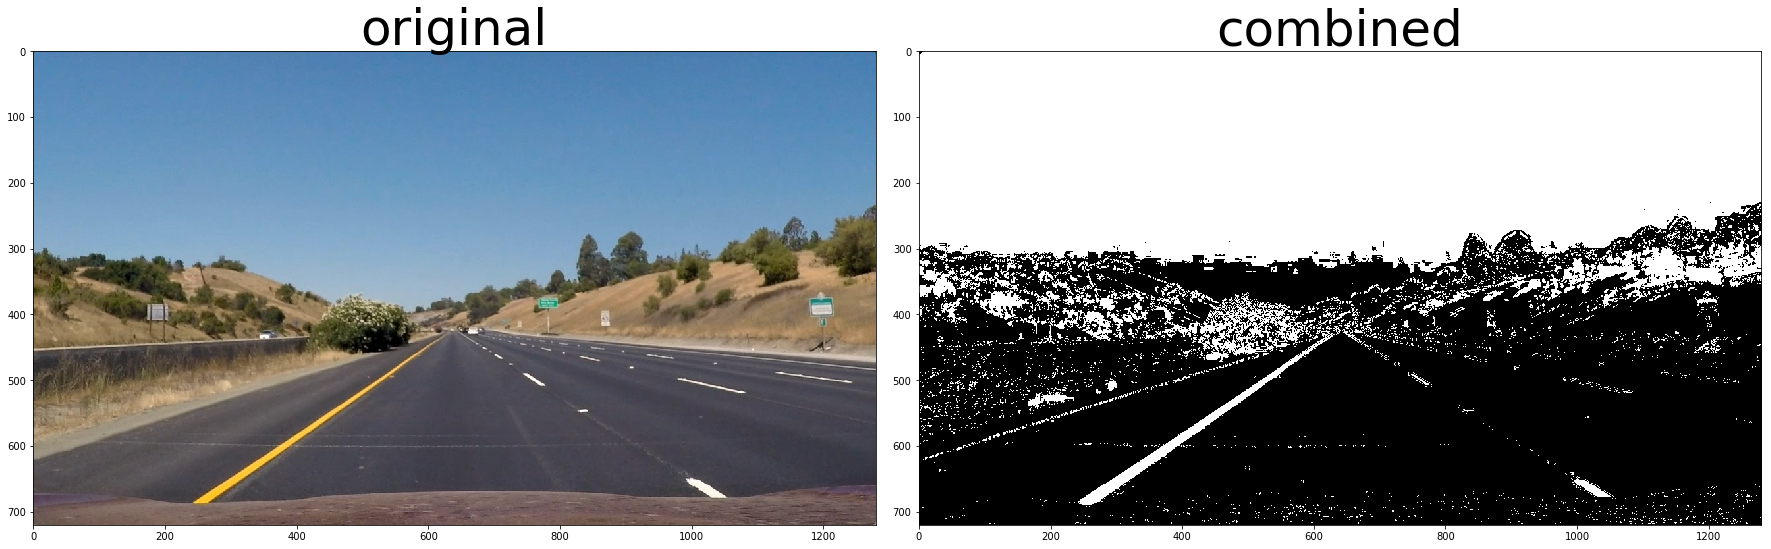

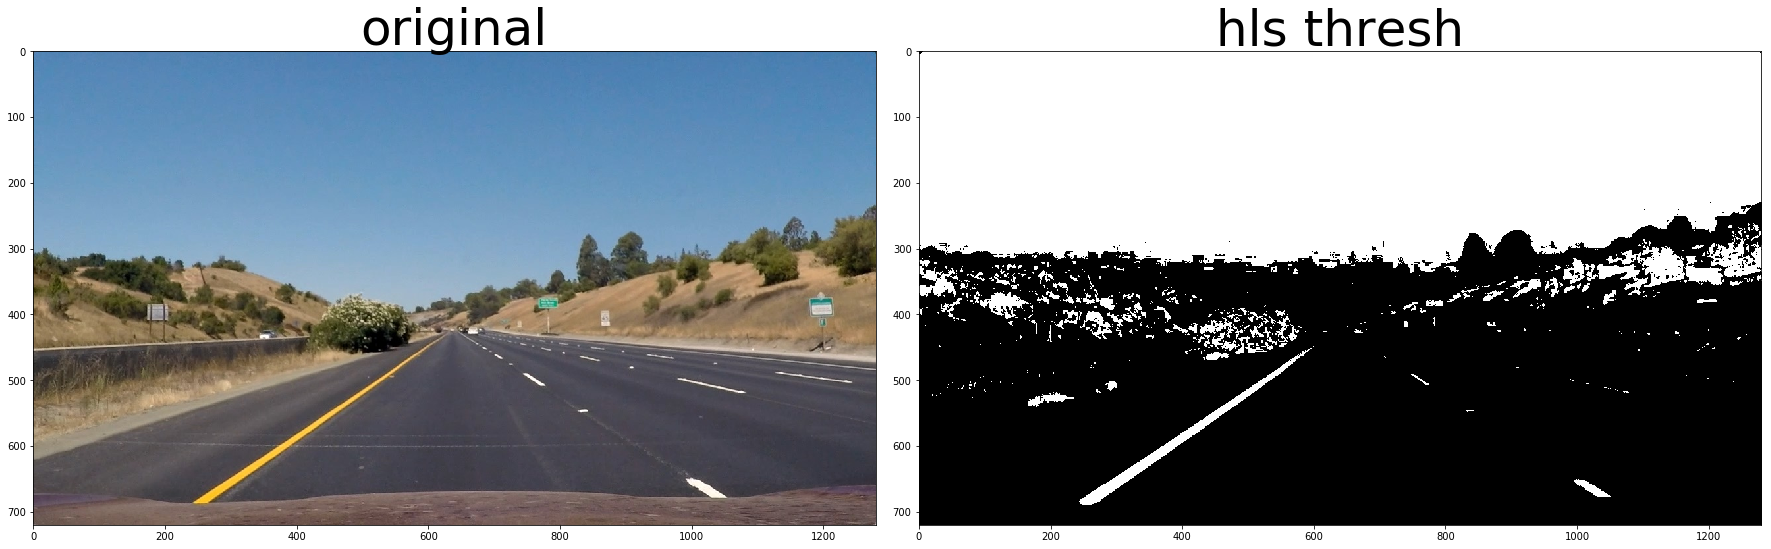

In [53]:
img = h.load_image('../test_images/straight_lines1.jpg')  
t = Thresholder()

op = t.absolute_threshold(img, orient='x', thresh_min=20, thresh_max=100, sobel_kernel=3)
# Plot the result
h.parallel_plots(img,'original', op, 'abs thresholded', None, 'gray')


op = t.magnitude_threshold(img, sobel_kernel=3, mag_thresh=(30, 100))
# Plot the result
h.parallel_plots(img,'original', op, 'mag thresholded', None, 'gray')

op = t.direction_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
h.parallel_plots(img,'original', op, 'dir thresholded', None, 'gray')


ksize=3
s_thres = t.hls_threshold(img, thresh=(90, 255))
gradx = t.absolute_threshold(img, orient='x', thresh_min=20, thresh_max=100, sobel_kernel=ksize)
grady = t.absolute_threshold(img, orient='y', thresh_min=20, thresh_max=100, sobel_kernel=ksize)
mag_binary = t.magnitude_threshold(img, sobel_kernel=ksize, mag_thresh=(20, 100))
dir_binary = t.direction_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))

op = np.zeros_like(dir_binary)
op[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_thres == 1)] = 1
h.parallel_plots(img,'original', op, 'combined', None, 'gray')


op = t.hls_threshold(img, thresh=(90, 255))
h.parallel_plots(img,'original', op, 'hls thresh', None, 'gray')
